In [1]:
suppressMessages(library(data.table))
suppressMessages(library(ggplot2))
suppressMessages(library(ggsci))
suppressMessages(library(magrittr))
suppressMessages(library(ggrepel))
suppressMessages(library(dplyr))
suppressMessages(library(ggpubr))
suppressMessages(library(RcppRoll))
options(warn=-1) # use options(warn=0) To turn warnings back on
options(dplyr.summarise.inform = FALSE)
source("../src/confidence_interval.r")
source("../src/plotRPFsmRNA.r")

In [2]:
setwd("/Users/inamojun/TMDU-LR_isoform_atlas/Figures")

In [3]:
#load data
load("../data/data_Fig05.RData")

In [4]:
# downsampling to downsize PDF file
nrow(TE90$mRNA)
set.seed(1234)
num = sample(1:nrow(TE90$mRNA),10000)
TE90$mRNA = TE90$mRNA[num,]
TE90$RPFs = TE90$RPFs[num,]
TE90$TE = TE90$TE[num,]

[1] 157499

pdf 
  2

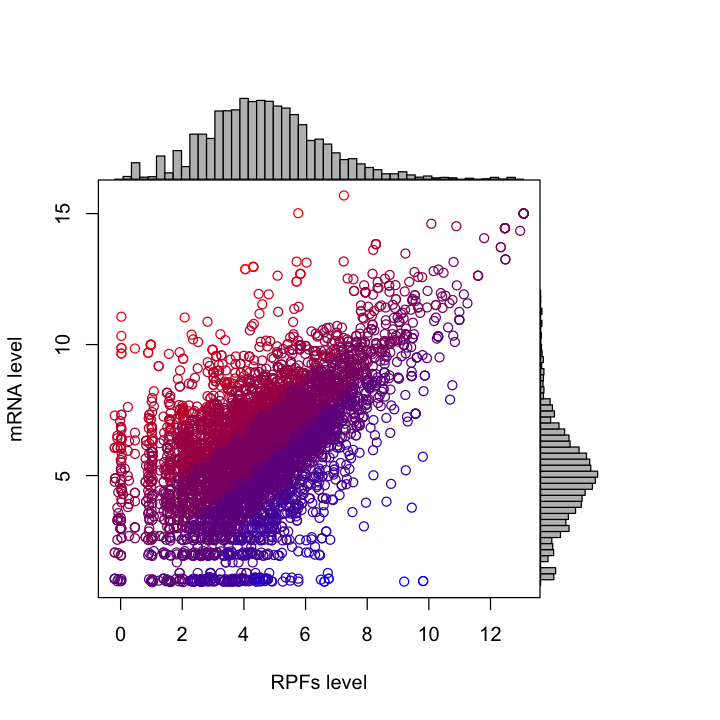

In [5]:
options(repr.plot.width=6, repr.plot.height=6)
plotRPFsmRNA(TE90, sample=5, log2=TRUE, pch=21, cex=1.6, alpha=c(scales::alpha('darkblue', 0.1)), color_TE=TRUE)
pdf("./Figure5a.pdf", width=6, height=6)
plotRPFsmRNA(TE90, sample=5, log2=TRUE, pch=21, cex=1.6, alpha=c(scales::alpha('darkblue', 0.1)), color_TE=TRUE)
dev.off()

In [6]:
# cor.test(te$med_te,te$five_utr_length,method="spearman")
# cor.test(te$med_te,te$three_utr_length,method="spearman")
# cor.test(te$med_te,te$CDS_length,method="spearman")
# cor.test(te$med_te,te$med_RNA,method="spearman")
# cor.test(te$med_te,te$med_ribo,method="spearman")
cor.test(te$normalized_med_te,te$normalized_five_utr_length,method="spearman")
cor.test(te$normalized_med_te,te$normalized_three_utr_length,method="spearman")
cor.test(te$normalized_med_te,te$normalized_CDS_length,method="spearman")
cor.test(te$normalized_med_te,te$kozak_score,method="spearman")


	Spearman's rank correlation rho

data:  te$normalized_med_te and te$normalized_five_utr_length
S = 1.4407e+14, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.2479024 



	Spearman's rank correlation rho

data:  te$normalized_med_te and te$normalized_three_utr_length
S = 1.0272e+14, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.110267 



	Spearman's rank correlation rho

data:  te$normalized_med_te and te$normalized_CDS_length
S = 1.0947e+14, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
0.05177468 



	Spearman's rank correlation rho

data:  te$normalized_med_te and te$kozak_score
S = 1.0483e+14, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.091976 


In [7]:
# downsampling to downsize PDF file
set.seed(1234)
nrow(te)
te = dplyr::sample_n(te,as.integer(nrow(te)*0.1))
nrow(te)

[1] 88480

[1] 8848

pdf 
  2

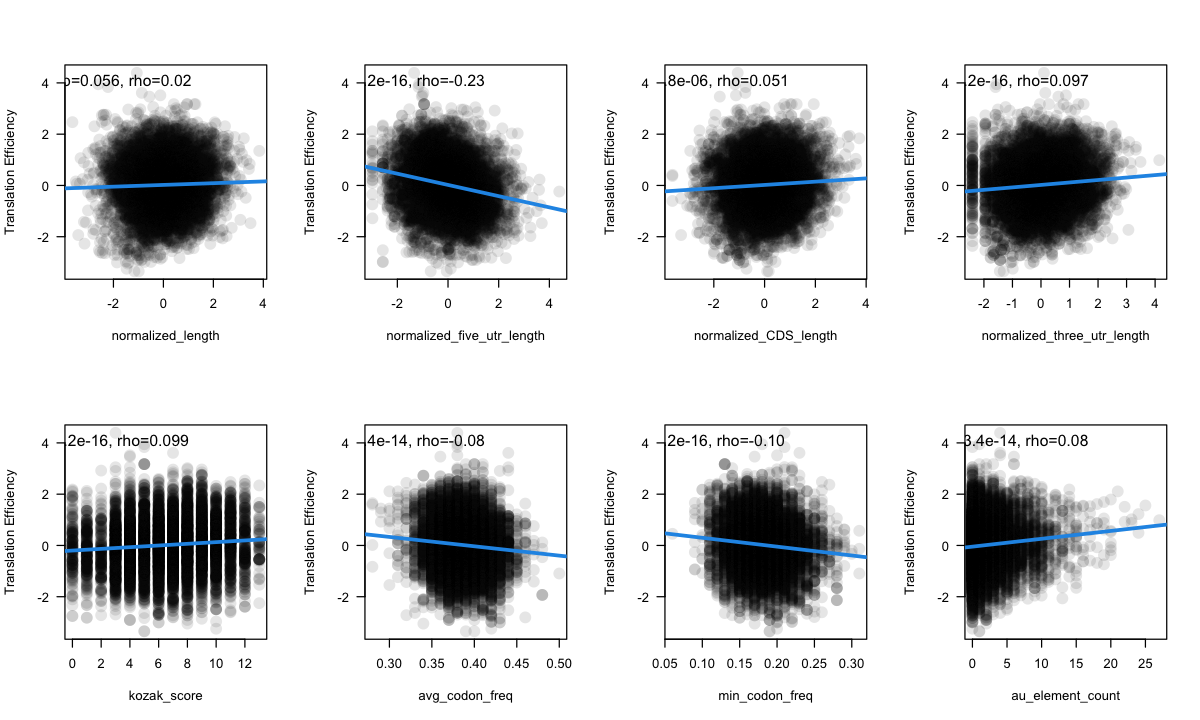

In [8]:
options(repr.plot.width=10, repr.plot.height=6)
par(mfrow=c(2,4))
for (i in c("normalized_length","normalized_five_utr_length","normalized_CDS_length","normalized_three_utr_length","kozak_score","avg_codon_freq","min_codon_freq","au_element_count","au_element_frac","max_au_length","MFE","centroid","MEA")) {
  x=eval(parse(text=paste0("te$",i)))
  y=te$normalized_med_te
  if(i=="kozak_score"){
    # something with a UTR that is less than 6nt is not likely to follow kozak behavior, so just setting the score to -1 to indicate oddball status 
    y = y[x!=-1]
    x = x[x!=-1]
  }
  # x=rnorm(10000, mean=0, sd=1)
  # y=rnorm(10000, mean=0, sd=1)
  test = cor.test(x,y,method="spearman")
  plot(x,y, las = 1, col = c(scales::alpha('black', 0.1)), cex = 2, pch=16, xlab = i, ylab = "Translation Efficiency");
  abline(lm(y ~ x), col = 4, lwd = 3)
  legend("top", cex = 1.2, col="red", legend = paste0(ifelse(test$p.value < 2.2e-16, "p<2.2e-16",paste0("p=",format(test$p.value, digit=2, nsmall=2))),", rho=",format(test$estimate, digit=2, nsmall=2)), 
         bty = "n")
}

pdf("./Figure5b.pdf", width=10, height=3)
par(mfrow=c(1,4))
for (i in c("kozak_score","normalized_five_utr_length","normalized_CDS_length","normalized_three_utr_length")) {
  x=eval(parse(text=paste0("te$",i)))
  y=te$normalized_med_te
  if(i=="kozak_score"){
    # something with a UTR that is less than 6nt is not likely to follow kozak behavior, so just setting the score to -1 to indicate oddball status 
    y = y[x!=-1]
    x = x[x!=-1]
    xlabel = "Kozak score"
  } else if (i=="normalized_five_utr_length"){
    xlabel = "normalized 5'UTR length"
  } else if (i=="normalized_CDS_length"){
    xlabel = "normalized ORF length"
  } else if (i=="normalized_three_utr_length"){
    xlabel = "normalized 3'UTR length"
  }
  # x=rnorm(10000, mean=0, sd=1)
  # y=rnorm(10000, mean=0, sd=1)
  test = cor.test(x,y,method="spearman")
  plot(x,y, las = 1, col = c(scales::alpha('black', 0.1)), cex.main=1.2, cex.lab=1.5, cex.axis=1, color="red", pch=16, xlab = xlabel, ylab = "Translation Efficiency");
  abline(lm(y ~ x), col = 4, lwd = 3)
  legend("top", cex = 1.2, col="red", legend = paste0(ifelse(test$p.value < 2.2e-16, "p<2.2e-16",paste0("p=",format(test$p.value, digit=2, nsmall=2))),", rho=",format(test$estimate, digit=2, nsmall=2)), 
         bty = "n")
}
dev.off()

In [9]:
dateRanges <- fold_energy_df %>%
  merge(.,te[,c("isoform","med_te")],by="isoform") %>%
  na.omit() %>% 
  dplyr::mutate(scaled_distance_from_cap_TSS2TTS_bin = round(scaled_distance_from_cap_TSS2TTS)) %>%
  dplyr::group_by(scaled_distance_from_cap_TSS2TTS_bin) %>%
  dplyr::summarize(cor_MFE_eff = -1*as.numeric(cor.test(MFE,med_te)$estimate),
                   cor_MFE_pvalue = cor.test(MFE,med_te)$p.value,
                   cor_MFE_LogP = -log10(as.numeric(cor.test(MFE,med_te)$p.value))
  ) %>%
  dplyr::ungroup() %>%
  dplyr::mutate(cor_MFE_eff = 
                  case_when(
                    scaled_distance_from_cap_TSS2TTS_bin == 0 ~  RcppRoll::roll_mean(cor_MFE_eff, n=5, weights = c(0,0,1,1,1), align="center", fill=NA),
                    scaled_distance_from_cap_TSS2TTS_bin == 1 ~  RcppRoll::roll_mean(cor_MFE_eff, n=5, weights = c(0,1,1,1,1), align="center", fill=NA),
                    scaled_distance_from_cap_TSS2TTS_bin == 299 ~  RcppRoll::roll_mean(cor_MFE_eff, n=5, weights = c(1,1,1,0,0), align="center", fill=NA),
                    scaled_distance_from_cap_TSS2TTS_bin == 300 ~  RcppRoll::roll_mean(cor_MFE_eff, n=5, weights = c(1,1,1,1,0), align="center", fill=NA),
                    TRUE ~ RcppRoll::roll_mean(cor_MFE_eff, n=5, weights = c(1,1,1,1,0), align="center", fill=NA)
                  ),
                cor_MFE_LogQ = -log10(qvalue::qvalue(as.numeric(cor_MFE_pvalue))$qvalues),
                cor_MFE_LogQ = RcppRoll::roll_mean(cor_MFE_LogQ, n=5, align="center", fill=NA) %>% ifelse(is.na(.), cor_MFE_LogQ, .),
                cor_MFE_pBF = ifelse((cor_MFE_pvalue*300)>1, 1, cor_MFE_pvalue*300),
                cor_MFE_LogpBF = -log10(cor_MFE_pBF),
                cor_MFE_LogpBF = RcppRoll::roll_mean(cor_MFE_LogpBF, n=5, align="center", fill=NA) %>% ifelse(is.na(.), cor_MFE_LogpBF, .)
  ) %>%
  as.data.frame() %>%
  dplyr::filter(cor_MFE_LogpBF>-log10(0.05) & cor_MFE_pBF<0.05) %>%
  dplyr::mutate(to = scaled_distance_from_cap_TSS2TTS_bin+1,
                tmp_lead_from = dplyr::lead(scaled_distance_from_cap_TSS2TTS_bin,1),
                tmp_lead_to = dplyr::lead(to,1),
                eff = case_when(
                  cor_MFE_eff>0 & (to == tmp_lead_from | to == tmp_lead_to) ~ "posi", 
                  cor_MFE_eff<0 & (to == tmp_lead_from | to == tmp_lead_to) ~ "nega",
                  TRUE ~ "nonsig")) %>%
  dplyr::filter(eff == "posi" | eff == "nega") %>%
  dplyr::mutate(rows = dplyr::row_number(),
                scaled_distance_from_cap_TSS2TTS_bin = case_when(
                  rows == 1 ~ scaled_distance_from_cap_TSS2TTS_bin-2,
                  TRUE ~ scaled_distance_from_cap_TSS2TTS_bin
                ),
                to = case_when(
                  rows == nrow(.) ~ to+2,
                  TRUE ~ to
                ))

options(repr.plot.width=8, repr.plot.height=6)
g = fold_energy_df %>%
  merge(.,te[,c("isoform","med_te")],by="isoform") %>%
  na.omit() %>%
  dplyr::mutate(scaled_distance_from_cap_TSS2TTS_bin = round(scaled_distance_from_cap_TSS2TTS)) %>%
  dplyr::group_by(scaled_distance_from_cap_TSS2TTS_bin) %>%
  dplyr::summarize(cor_MFE_eff = -1*as.numeric(cor.test(MFE,med_te)$estimate),
                   cor_MFE_pvalue = cor.test(MFE,med_te)$p.value,
                   cor_MFE_LogP = -log10(as.numeric(cor.test(MFE,med_te)$p.value))
  ) %>%
  dplyr::ungroup() %>%
  dplyr::mutate(cor_MFE_eff = 
                  case_when(
                    scaled_distance_from_cap_TSS2TTS_bin == 0 ~  RcppRoll::roll_mean(cor_MFE_eff, n=5, weights = c(0,0,1,1,1), align="center", fill=NA),
                    scaled_distance_from_cap_TSS2TTS_bin == 1 ~  RcppRoll::roll_mean(cor_MFE_eff, n=5, weights = c(0,1,1,1,1), align="center", fill=NA),
                    scaled_distance_from_cap_TSS2TTS_bin == 299 ~  RcppRoll::roll_mean(cor_MFE_eff, n=5, weights = c(1,1,1,0,0), align="center", fill=NA),
                    scaled_distance_from_cap_TSS2TTS_bin == 300 ~  RcppRoll::roll_mean(cor_MFE_eff, n=5, weights = c(1,1,1,1,0), align="center", fill=NA),
                    TRUE ~ RcppRoll::roll_mean(cor_MFE_eff, n=5, weights = c(1,1,1,1,0), align="center", fill=NA)
                  ),
                cor_MFE_LogQ = -log10(qvalue::qvalue(as.numeric(cor_MFE_pvalue))$qvalues),
                cor_MFE_LogQ = RcppRoll::roll_mean(cor_MFE_LogQ, n=5, align="center", fill=NA) %>% ifelse(is.na(.), cor_MFE_LogQ, .),
                cor_MFE_pBF = ifelse((cor_MFE_pvalue*300)>1, 1, cor_MFE_pvalue*300),
                cor_MFE_LogpBF = -log10(cor_MFE_pBF),
                cor_MFE_LogpBF = RcppRoll::roll_mean(cor_MFE_LogpBF, n=5, align="center", fill=NA) %>% ifelse(is.na(.), cor_MFE_LogpBF, .)
  ) %>%
  as.data.frame() %>%
  ggplot(., aes(x=scaled_distance_from_cap_TSS2TTS_bin,y=cor_MFE_eff)) + 
  # geom_smooth(method = "loess", aes(color=..y..), size=1.5, se=FALSE) +
  geom_point(aes(x=scaled_distance_from_cap_TSS2TTS_bin,y=cor_MFE_eff,color=..y..), alpha=1, size=1) + 
  scale_colour_gradient2(low = "#0072B5FF", mid = "grey" , high = "#BC3C29FF", 
                         midpoint=0) +
  geom_line(aes(x=scaled_distance_from_cap_TSS2TTS_bin,y=cor_MFE_LogpBF/300)) + 
  geom_rect(data = dateRanges, aes(xmin = scaled_distance_from_cap_TSS2TTS_bin, xmax = to, ymin = -Inf, ymax = Inf, fill = eff), alpha = 0.2) +
  scale_fill_manual(values=c("posi" = "pink", "nega" = "turquoise3")) +
  ggtitle("Correlation between local folding strength and translational efficiency") +
  ylab(paste0("correlation coefficient")) +
  xlab("scaled position in gene body") +
  scale_x_continuous(labels=c("TSS","ORFstart","ORFend","TTS"), breaks=c(0,100,200,300), limits=c(0,300)) +
  scale_y_continuous(sec.axis = sec_axis(~.*300, name = "-log10(Bonferroni adjusted p-value)", breaks = seq(0, 150, 5))) +
  geom_vline(xintercept = 100,linetype="dashed",colour="grey") +
  geom_vline(xintercept = 200,linetype="dashed",colour="grey") +
  geom_hline(yintercept = 0,colour="black") +
  # geom_hline(yintercept = 1.3/1000,linetype="dashed",colour="black") +
  theme_minimal() +
  theme(strip.text.x=element_text(size=20, color="black", face="bold"),
        strip.text.y=element_text(size=20, color="black", face="bold"),
        panel.grid=element_blank(),
        legend.position = "bottom",
        plot.title = element_text(size=20),
        axis.title.x = element_text(size=18),
        axis.title.y = element_text(size =18),
        axis.text.y = element_text(size = 20),
        axis.text.x = element_text(size = 20),
        legend.text =  element_text(size = 20), 
        legend.key.size = grid::unit(0.8, "lines"),
        legend.title = element_text(size = 0, hjust = 0))
g
pdf("./Figure5c.pdf", width=8, height=6)
g
dev.off()

ERROR: [1m[33mError[39m in [1m[1m`dplyr::summarize()`:[22m
[1m[22m[33m![39m Problem while computing `cor_MFE_eff = -1 * as.numeric(cor.test(MFE,
  med_te)$estimate)`.
[36mℹ[39m The error occurred in group 301: scaled_distance_from_cap_TSS2TTS_bin = 300.
[1mCaused by error in [1m[1m`cor.test.default()`:[22m
[33m![39m not enough finite observations
